## Firstly all imports are done, Tensorflow will be used to create our word generation model

In [1]:
import tensorflow as tf
import pickle
import numpy as np
import os
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from google.colab import files

In [2]:
# Upload any folder to your liking but add its name to function in next cell and make sure it uses URT8 encoding
upload = files.upload()

Saving 1661-0.txt to 1661-0.txt


### The next function acts as text file tokenizer converting the text file into a very long array of words. This treats the book as a stream of continous words that makes sense which is not correct and should be changed but it was done just for simplicity.
*(Preproccesing on the text file and droping unwanted lines should be done before this step)*

In [5]:
def read_text_from_file(filename):
  f = open(filename, 'r', encoding='utf8')

  lines = []
  data=''

  for line in f:
    lines.append(line)
  for line in lines:
    data = ' '.join(lines)

  data = data.replace('\n', ' ').replace('\r', ' ').replace('\ufeff', ' ')
  data = data.split()
  data = ' '.join(data)
  data = data.lower()
  return data

In [6]:
# Change the file name to your uploaded file name
filename = '1661-0.txt'
data = read_text_from_file(filename)
data[:200]

'the project gutenberg ebook of the adventures of sherlock holmes, by arthur conan doyle this ebook is for the use of anyone anywhere in the united states and most other parts of the world at no cost a'

## Secondly, using a tokenizer we will convert each unique word to an index
*so now we just want to predict the next index, by finding what is the most likely index to appear after an array of a specific number of words*

In [7]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts([data])

pickle.dump(tokenizer, open('wordPredv4.pkl', 'wb'))


sequence_data = tokenizer.texts_to_sequences([data])[0]
vocab_size = len(tokenizer.word_index) + 1


In [8]:
print(sequence_data[:10])
print(len(sequence_data))
print(vocab_size)
print(len(data))

[1, 144, 131, 885, 4, 1, 1092, 4, 129, 34]
111201
8913
578417


### The next two function are used to split the data and find the word using its key index

In [9]:
def create_train_test(var, sequence_data):
  X = []
  y = []

  for i in range(var, len(sequence_data)):
    words = sequence_data[i-var:i]
    X.append(words)
    y.append(sequence_data[i])

  X = np.array(X)
  y = np.array(y)

  return X, y

In [10]:
def find_word(val):
    for key, value in tokenizer.word_index.items():
      if value == val:
          return key

In [12]:
#variable (var) is the sequence length used
var = 5

X, y = create_train_test(var=var, sequence_data=sequence_data)

In [13]:
print(len(X))
print(len(y))
print(len(X[1]))

111196
111196
5


In [14]:
print(f'{X[1]} \n {y[1]}')
print(f'{find_word(X[1][0])} {find_word(X[1][1])} {find_word(X[1][2])} {find_word(X[1][3])} {find_word(X[1][4])} {find_word(y[1])}')

[144 131 885   4   1] 
 1092
project gutenberg ebook of the adventures


## Now we convert the labels to categorical labels as we want the model to predict the probability of each word.
*keep in mind that we didn't limit our vocabulary which can make this very memory consuming*

In [15]:
y = to_categorical(y, num_classes=vocab_size)

y[:3]

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
print(X.shape)
print(y.shape)

(111196, 5)
(111196, 8913)


## Glove 200d will be used as our embeddings instead of training our own embeddings
*(weight initialization)*

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-02-12 10:11:19--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-02-12 10:11:19--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-02-12 10:11:19--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [18]:
!unzip glove*.zip
!rm glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [19]:
# Load the embeddings in a dictionary
embedding_dict = {}
with open('/content/glove.6B.200d.txt', 'r') as f:
  for line in f:
    values = line.split()
    word = values[0]
    vectors = np.asarray(values[1:], 'float32')
    embedding_dict[word] = vectors

f.close()

print('Loaded word vectors',len(embedding_dict))

Loaded word vectors 400000


In [20]:
# Create an embedding 200d matrix and get all the word embeddings in our tokenizer
embedding_matrix = np.zeros((vocab_size,200))

for word, i in tokenizer.word_index.items():
  if i < vocab_size:
    emb_vec = embedding_dict.get(word)
    if emb_vec is not None:
      embedding_matrix[i] = emb_vec

## Finally we create our Model using LSTM
*Future version will use perplexity instead of CategoricalCrossentropy and more models will be added to compare outputs*

In [25]:
from tensorflow.keras.losses import CategoricalCrossentropy
optimizer = Adam(learning_rate=0.0001)
loss_function = CategoricalCrossentropy()
additional_metrics = ['accuracy']
epochs = 20
verbosity_mode = 1

In [22]:
model = Sequential()
model.add(Embedding(vocab_size,200,weights=[embedding_matrix],trainable=False,input_length=var))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
  
model.add(Dense(100, activation='relu'))
model.add(Dense(vocab_size, activation='softmax'))

# summarize defined model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5, 200)            1782600   
                                                                 
 lstm (LSTM)                 (None, 5, 100)            120400    
                                                                 
 lstm_1 (LSTM)               (None, 150)               150600    
                                                                 
 dense (Dense)               (None, 100)               15100     
                                                                 
 dense_1 (Dense)             (None, 8913)              900213    
                                                                 
Total params: 2,968,913
Trainable params: 1,186,313
Non-trainable params: 1,782,600
_________________________________________________________________


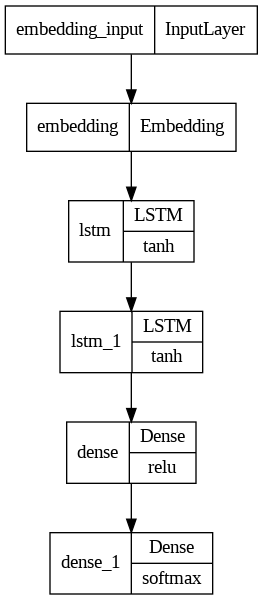

In [23]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

plot_model(model, show_layer_names=True, show_layer_activations=True, to_file='model.png')

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint('word_predv4.h5', monitor='val_accuracy', save_best_only=True, verbose=verbosity_mode)
# compile network
model.compile(loss=loss_function, optimizer=optimizer, metrics=additional_metrics)

In [27]:
#training
val_split = 0.2

history = model.fit(X, y, epochs=epochs, validation_split=val_split, batch_size=64, callbacks=[checkpoint])

Epoch 1/20
1389/1390 [============================>.] - ETA: 0s - loss: 6.8162 - accuracy: 0.0490
Epoch 1: val_accuracy improved from -inf to 0.04820, saving model to word_predv4.h5
1390/1390 [==============================] - 107s 73ms/step - loss: 6.8160 - accuracy: 0.0490 - val_loss: 6.8415 - val_accuracy: 0.0482
Epoch 2/20
1390/1390 [==============================] - ETA: 0s - loss: 6.4549 - accuracy: 0.0523
Epoch 2: val_accuracy did not improve from 0.04820
1390/1390 [==============================] - 113s 81ms/step - loss: 6.4549 - accuracy: 0.0523 - val_loss: 6.8969 - val_accuracy: 0.0482
Epoch 3/20
1389/1390 [============================>.] - ETA: 0s - loss: 6.4072 - accuracy: 0.0523
Epoch 3: val_accuracy did not improve from 0.04820
1390/1390 [==============================] - 95s 69ms/step - loss: 6.4075 - accuracy: 0.0523 - val_loss: 6.9290 - val_accuracy: 0.0482
Epoch 4/20
1390/1390 [==============================] - ETA: 0s - loss: 6.3439 - accuracy: 0.0550
Epoch 4: val_ac

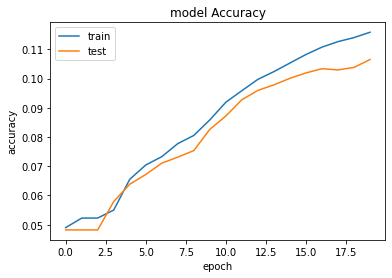

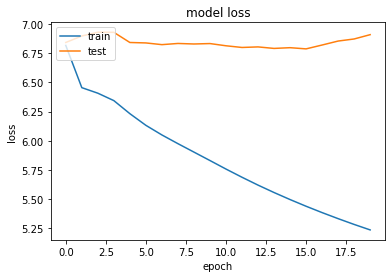

In [28]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Here we can test the model using our sentences
*keep in mind that the model have only seen the sentences in the book*

In [29]:
text = 'it was clear that killer was'
sequence = tokenizer.texts_to_sequences([text])
sequence = np.array(sequence)

out = model.predict(sequence)

print(len(out))
print(out)
print(out.shape)
sorted_index_array = np.argsort(out)
outs = sorted_index_array[0][-5:]
print(outs)

for i in outs:
  word = find_word(i)
  print(word)

1/1 [==============================] - 1s 1s/step
1
[[1.2431484e-10 3.7689231e-02 1.5654247e-03 ... 1.2974347e-10
  1.2728886e-10 1.1430161e-10]]
(1, 8913)
[44 51  1 41  5]
very
no
the
been
a


### These functions are used to predict and find the next word

In [30]:
from tensorflow.keras.models import load_model
import pickle
import numpy as np

model = load_model('word_predv4.h5')
tokenizer = pickle.load(open('wordPredv4.pkl', 'rb'))

In [31]:
def word_pred(model, tokenizer, text):
  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  return np.argmax(model.predict(sequence))

def new_text(model, tokenizer, text):
  text = text.split(' ')
  seq= text[(-1*var):]
  word = find_word(word_pred(model, tokenizer, seq))
  text.append(word)
  text = ' '.join(text)
  return text

## TRY IT !!!

In [36]:
while(True):
  num = int(input("number of words to predict ('0' to exit)\n"))
  if num == 0:
    print('<<<<<Thank you for using this model>>>>>')
    break
  text = input("Enter your line \n")
  text = text.lower()


  try:
    for i in range(num):
      text = new_text(model, tokenizer, text)
    
    print('\n', text, '\n')

  except Exception as e:
        print("Error occurred: ",e)
        continue

number of words to predict ('0' to exit)
5
Enter your line 
there was a big doll behind the
1/1 [==============================] - 0s 25ms/step

 there was a big doll behind the door and the other of 

number of words to predict ('0' to exit)
0
<<<<<Thank you for using this model>>>>>
